# Resnet finetuning

On this page, we consider the process of model fine-tuning. This involves taking a pre-trained model and adapting it for your specific purposes by modifying only certain parts of the model. As an example, we'll use the ResNet model to solve the CIFAR-10 classification problem, even though ResNet was not originally designed for this task.

In [23]:
import json
import tqdm
import urllib
from itertools import chain

from pathlib import Path
files_path = Path("./resnet_finetuning_files")
files_path.mkdir(exist_ok=True)

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights

train_dataset = CIFAR10(
    root=str(files_path),
    train=True,
    download=True,
    transform=T.ToTensor()
)
test_dataset = CIFAR10(
    root=str(files_path),
    train=False,
    download=True,
    transform=T.ToTensor()
)
(files_path/".gitignore").write_text("cifar-10*")

train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("using device", device)

Files already downloaded and verified
Files already downloaded and verified
using device cpu


## Resnet

Consider the model we'll use as an example.

In [ ]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.requires_grad_(False)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Ok, and check how it performs on our dataset by default. The following cell shows the predictions of the basic ResNet model on some images.

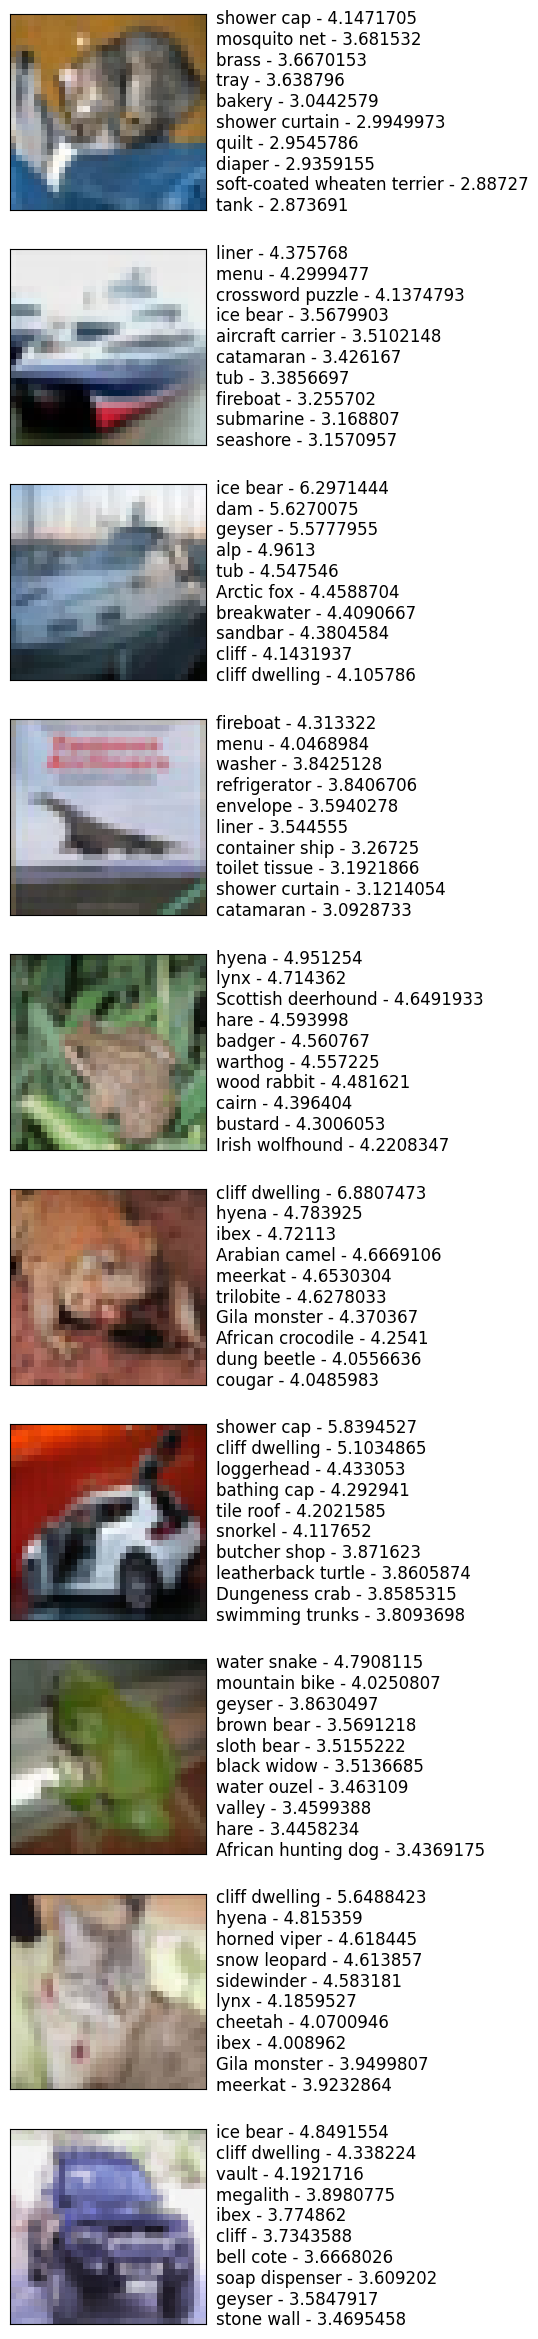

In [ ]:
images_number = 10

# Downloading labels of the image net - the dataset that was trained for
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
filename, _ = urllib.request.urlretrieve(url)
with open(filename, 'r') as f:
    imagenet_labels = np.array([line.strip() for line in f.readlines()])

# Take an image from the test dataset and pass it through the network.
images = torch.stack([test_dataset[i][0] for i in range(images_number)])
predict = model(images)
# Extract the labels of the most likely classes along with the predicted scores
top10_classes = predict.argsort(descending=True)[:, :10].numpy()
label = imagenet_labels[top10_classes]
predict = predict[np.arange(predict.shape[0])[:, None], top10_classes].numpy()
# For each image, create a line that describes the network's decision
describe_predict = np.char.add(np.char.add(label, ' - '), predict.astype("str"))
describe_predict = np.array(['\n'.join(row) for row in describe_predict])

fig, axes = plt.subplots(nrows=images_number, ncols=1, figsize=(50, 30))

for i, ax in enumerate(axes):
    ax.imshow(T.ToPILImage()(images[i]))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(
        x=1.05, y=0.5,
        s=describe_predict[i],
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='center'
    )

The results are questionable. So we'll search the way to adapt resnet for CIFAR10 dataset.

## Training code

There is almost nothing special about the training code for finetuning. The following cell implements some auxiliary functions—these are entirely common and don't have any features specific to the procedure considered in this notebook.

In [2]:
def get_model_devive(model: torch.nn.Module) -> torch.device:
    '''
    Get device used by a specified model.

    Parameters
    ----------
    model: torch.nn.Module
        Model under consideration.

    Returns
    -------
    out: torch.device
        Device used by model.
    '''

    result = None

    for param in model.parameters():
        if result is None:
            result = param.device
        else:
            if result != param.device:
                raise ValueError(
                    "Different parameters of the model have different devices!"
                )

    return result


def get_predics(
    model: torch.nn.Module, loader: DataLoader
) -> tuple[torch.Tensor, torch.Tensor]:
    '''
    Extract predictions and corresponding targets.

    Parameters
    ----------
    model: torch.nn.Module
        The model for which predictions are required.
    loader: DataLoader
        Dataloader that iterates over samples.

    Returns
    -------
    out: tuple[torch.Tensor, torch.Tensor]
        - Predicst of the model for each sample.
        - Actual target value for each sample.
    '''
    predicts = []
    targets = []

    device = get_model_devive(model=model)

    for X, y in loader:
        X = X.to(device=device)
        y = y.to(device=device)
        predicts.append(model(X))
        targets.append(y)

    return torch.cat(predicts), torch.cat(targets)


def estimate_loss_and_accuracy(
    model: torch.nn.Module, loader: DataLoader
) -> tuple[float, float]:
    '''
    Estimate loss and accuracy of given model on given dataset.

    Parameters
    ----------
    model: torch.nn.Module
        The model under consideration.
    loader: DataLoader
        DataLoader on which we'll estimate model.

    Returns
    -------
    out: tuple[float, float]
        - Loss on the given dataloader.
        - Accuracy on the given dataloader.
    '''

    loss_function = torch.nn.functional.cross_entropy
    predict, target = get_predics(model=model, loader=loader)
    accuracy = (predict.argmax(axis=1) == target).to(torch.float).mean()

    return loss_function(input=predict, target=target).item(), accuracy.item()

The only notable feature associated with model training is that, for the optimizer, it doesn't specify all the parameters of the network. Instead, there's an option to specify custom parameters that will be considered by the optimizer.

In [3]:
def train(
    model: torch.nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    params: torch.nn.parameter.Parameter|None = None,
    epoch_count: int = 1
) -> tuple[list[float], list[float], list[float]]:
    '''
    Function that implements model training.

    Parameters
    ----------
    model: torch.nn.Module
        Model that requires training.
    train_loader: DataLoader
        DataLoader used for model training.
    test_loader: DataLoader
        DataLoader used for model evaluation.
    params: torch.nn.parameter.Parameter | None = None
        Parameters that the optimizer will consider for optimization.
    epoch_count: int = 1
        Number of epochs for model training.

    Returns
    -------
    out: tuple[list[float], list[float], list[float]]
        - Losses on the training batches at each step.
        - Losses on the test dataset at each epoch.
        - Accuracies on the training dataset at each epoch.
    '''
    if params is None:
        params = model.parameters()

    device = get_model_devive(model=model)

    optim = torch.optim.Adam(params=params, lr=0.0001)
    loss_function = torch.nn.functional.cross_entropy

    loss_value, accuracy = estimate_loss_and_accuracy(model=model, loader=test_loader)

    train_losses = []
    test_losses = [loss_value]
    test_accuracies = [accuracy]

    for epoch in range(epoch_count):
        description_line = (
            f"epoch - {epoch + 1}, "
            f"loss - {round(test_losses[-1], 5)}, "
            f"accuracy - {round(test_accuracies[-1], 5)}"
        )
        for X, y in tqdm.tqdm(train_loader, desc=description_line):
            X = X.to(device=device)
            y = y.to(device=device)

            optim.zero_grad()

            predict = model(X)
            loss_value = loss_function(input=predict, target=y)
            train_losses.append(loss_value.item())

            loss_value.backward()
            optim.step()

        with torch.no_grad():
            loss_value, accuracy = estimate_loss_and_accuracy(model=model, loader=test_loader)
            test_losses.append(loss_value)
            test_accuracies.append(accuracy)

    return train_losses, test_losses, test_accuracies

## Model's head

First, let's replace only the head of the model, specifically the last fully connected layer that makes the final decision. This layer will return the number of classes available in CIFAR10, which we want to predict. This technique is actually called *transfer learning*.

In [ ]:
torch.manual_seed(10)

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.requires_grad_(False)
model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=10
)
model.fc.requires_grad_(True)

Linear(in_features=512, out_features=10, bias=True)

The following cell computes for a long time. The resulst will be reviewd in the following cell.

In [ ]:
model.to(device=device)

training_process = {}
(
    training_process["train_losses"],
    training_process["test_losses"],
    training_process["test_accuracies"]
) = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    params=model.fc.parameters(),
    epoch_count=10
)

with open(
    file=files_path/"only_head_training_progress.json", mode="w"
) as f:
    json.dump(obj=training_process, fp=f)

epoch - 10, loss - 1.62339, accuracy - 0.4467: 100%|██████████| 391/391 [00:11<00:00, 35.44it/s]


What's important here is that the model significantly improves its accuracy during the fitting procedure, demonstrating that our finetuning pipeline is effective and working as expected.

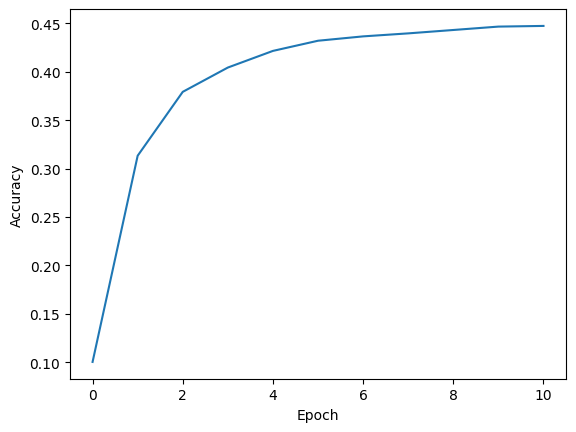

In [ ]:
with open(
    file=files_path/"only_head_training_progress.json", mode="r"
) as f:
    training_progress = json.load(f)

plt.plot(training_progress["test_accuracies"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Last layer

In the previous section, we focused on improving only the head of the model—the fully connected layer that makes decisions. Now, we will tackle a more complex case by trying to improve the weights of the last layer specifically for our task. The following cell defines a network that uses the head specified for the CIFAR10 case and also sets `require_grad_(True)` for `layer4`. Additionally, it prepares a parameters generator that will allow the optimizer to understand which parameters should be changed at each step.

In [24]:
torch.manual_seed(10)

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.requires_grad_(False)

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=10
)
model.fc.requires_grad_(True)
# !Game changer!
model.layer4 = model.layer4.requires_grad_(True)
fitting_parameters = chain(
    model.fc.parameters(),
    model.layer4.parameters()
)

Here is the call to the fitting procedure for the current case. Only 3 epochs are chosen to prevent overfitting, which was observed during experiments with this model.

If you have a GPU, the following cell executes quickly. If not, you can skip it; the results are visualized in the subsequent cells.

In [18]:
model.to(device=device)

training_process = {}
(
    training_process["train_losses"],
    training_process["test_losses"],
    training_process["test_accuracies"]
) = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    params=fitting_parameters,
    epoch_count=3
)

with open(
    file=files_path/"last_layer_training.json", mode="w"
) as f:
    json.dump(obj=training_process, fp=f)

epoch - 3, loss - 1.07325, accuracy - 0.6355: 100%|██████████| 391/391 [00:09<00:00, 41.44it/s]


In just a few epochs, we achieved an accuracy of over 0.6.

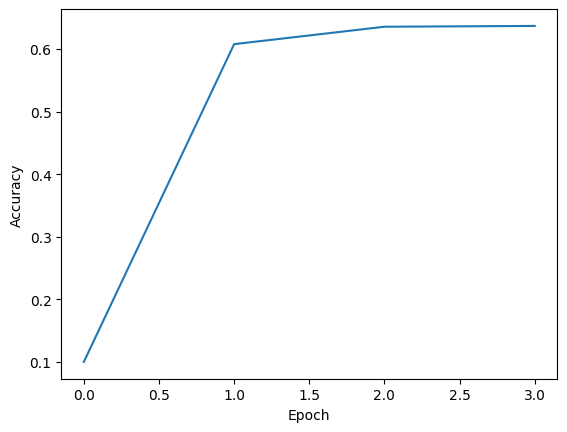

In [21]:
with open(
    file=files_path/"last_layer_training.json", mode="r"
) as f:
    training_progress = json.load(f)

plt.plot(training_progress["test_accuracies"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Conclusion

Finally, let's check what we've achieved with fine-tuning by returning to the pictures we initially tried to classify.

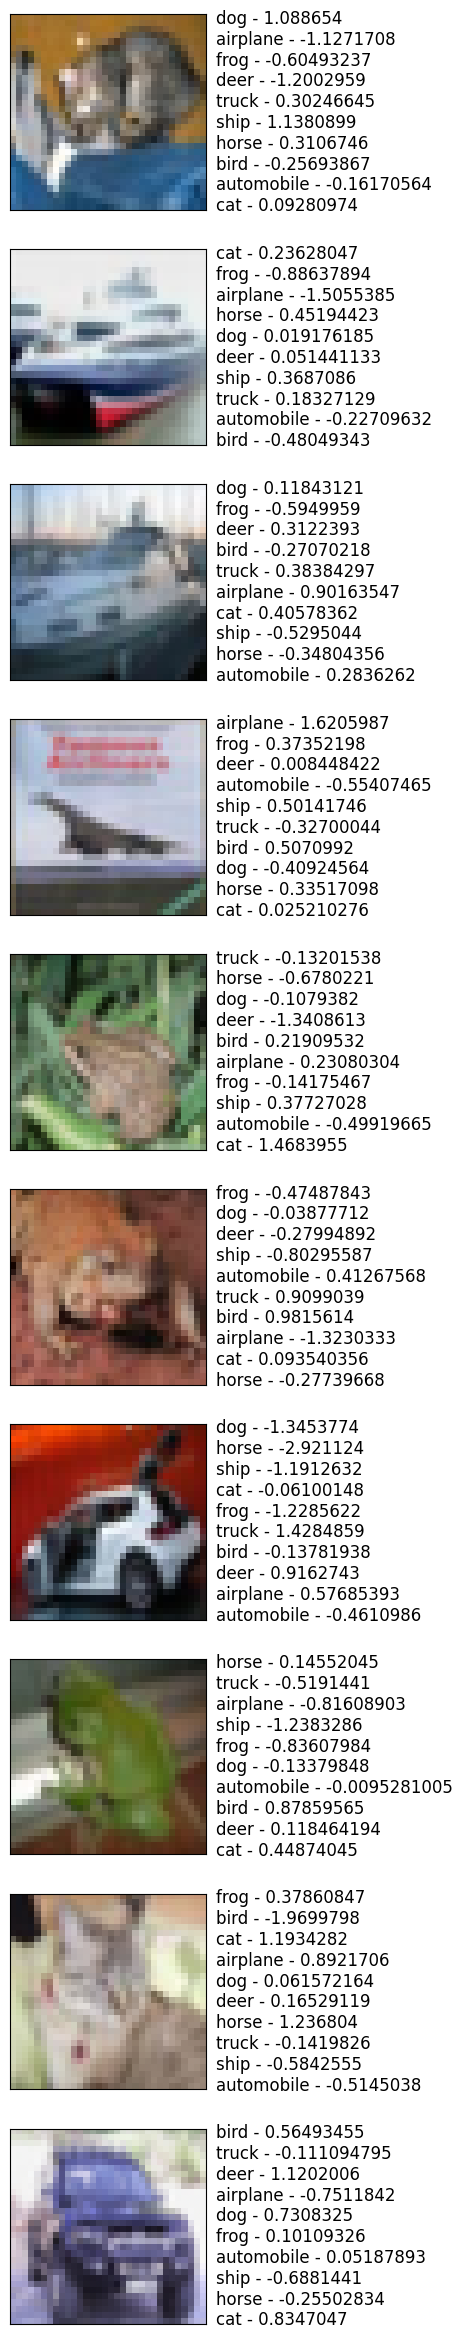

In [43]:
images_number = 10

# Take an image from the test dataset and pass it through the network.
images = torch.stack([test_dataset[i][0] for i in range(images_number)])
with torch.no_grad():
    predict = model(images)

cifar10_labels = np.array([
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
])

top10_classes = predict.argsort(descending=True).numpy()
label = cifar10_labels[top10_classes]

describe_predict = np.char.add(np.char.add(label, ' - '), predict.numpy().astype("str"))
describe_predict = np.array(['\n'.join(row) for row in describe_predict])

fig, axes = plt.subplots(nrows=images_number, ncols=1, figsize=(50, 30))

for i, ax in enumerate(axes):
    ax.imshow(T.ToPILImage()(images[i]))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(
        x=1.05, y=0.5,
        s=describe_predict[i],
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='center'
    )

Since we changed the head of the model, we are now dealing with labels that correspond to the original dataset. The classification isn't perfect yet, but it is much closer to the truth—good enough for a tutorial that demonstrates how a model can be fine-tuned in PyTorch.